In [539]:
## From: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

#import get to call a get request on the site
from requests import get

#get the first page of the housing prices
response = get('https://minneapolis.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print( len(posts)) #to double check I got 120 (elements/page)
post = posts[5]

<class 'bs4.element.ResultSet'>
120


In [540]:
print(post)

<li class="result-row" data-pid="7130543450" data-repost-of="6996976166">
<a class="result-image gallery" data-ids="1:00303_2t7Gpl8z3Vz,1:00q0q_eJ7pVHNk9q6,1:00v0v_1QcWtwa3oam,1:00H0H_bGdWBNtviZG,1:00303_3by3Cmy6YMw,1:00i0i_kYC47XR0INE,1:00s0s_weTOE5epF4,1:00A0A_9iRxzhPBHDq,1:00M0M_4Ai5fs8gDJt,1:00T0T_BVcDW9ezxd,1:00X0X_5QncQad0SGi,1:00p0p_lRpZbRdSt1x,1:00A0A_3GEoz66c1mz,1:00303_2ZtayoQGBK7,1:00404_ljBcN58VAwa,1:00o0o_pSkTAwFERJ,1:00O0O_78AFXKds13G,1:00F0F_6VNipTa0gvU,1:00d0d_xjd3UGtEaL,1:00909_3LsuGrkJAhY" href="https://minneapolis.craigslist.org/ram/apa/d/saint-paul-1-2-bedrooms-st-paul-pet/7130543450.html">
<span class="result-price">$920</span>
</a>
<p class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-text">favorite this post</span>
</span>
<time class="result-date" datetime="2020-06-02 09:24" title="Tue 02 Jun 09:24:06 AM">Jun  2</time>
<a class="result-title hdrlnk" data-id="7130543450" href="https://minneapolis.craigslist.org/ram/apa/d/s

In [541]:
curtime = post.find('time',class_='result-date')['datetime']
print(curtime)
cururl = post.find('a',class_='result-title hdrlnk')['href']
print(cururl)

2020-06-02 09:24
https://minneapolis.craigslist.org/ram/apa/d/saint-paul-1-2-bedrooms-st-paul-pet/7130543450.html


In [542]:
#curbrs = post.find('span', class_ = 'housing').text.split()[0][:-2]
#print(curbrs)

#cursqft = post.find('span', class_ = 'housing')
#if cursqft:
#    cursqft = cursqft.text.split()[2][:-3] #cleans the ft2 at the end
#    print(cursqft)
#print(cursqft)

curhood = post.find('span', class_='result-hood') 
if curhood:
    curhood = curhood.text
    print(curhood)



 (St Paul / East Side)


In [649]:
from geopy.geocoders import Nominatim, ArcGIS
curmap = BeautifulSoup(get(cururl).text,'html.parser').find_all('div',class_='mapbox')[0]
geolocator = Nominatim(user_agent="darren")

print(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])

location = geolocator.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])


geolocator2 = ArcGIS(user_agent="darren")
location2 = geolocator2.reverse(query=curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'],
                                distance=500)







loc = geolocator.reverse(query=str(np.round(float(curmap.find('div')['data-latitude'])-.001,3))
                   +","
                   +str(np.round(float(curmap.find('div')['data-longitude'])-.001,3)))
    
print(location.address)
print(location2.address)
print(loc.address)

#print(location.raw['address'])
#print(location.raw['address']['city'])
#print(location.raw['address']['neighbourhood'])
#print(location.raw['address']['postcode'])

44.955012,-93.045237
442, North English Street, St. Paul, Ramsey County, Minnesota, 55106, United States of America
446 English St, Saint Paul, Minnesota 55106, USA
1294, Wilson Avenue, Highwood, St. Paul, Ramsey County, Minnesota, 55106, United States of America


In [428]:
curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
print(curmap)

[<div class="mapbox">
<div class="viewposting" data-accuracy="22" data-latitude="44.946600" data-longitude="-93.286200" id="map"></div>
</div>]


In [ ]:
#new code to put here:
#get list of neighborhoods
#for each neighborhood,
#  get central coordinate
#for each posting
#  calculate distance from neighborhoods' centers
#  assign neighborhood based on nearest neighbor

In [595]:
#build out the loop
from time import sleep, time
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from IPython.core.display import clear_output
import numpy as np

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="derinkuyu",timeout=3)

#
TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street partking':5,
    'valet parking':6,
    'no parking':7
}


#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []


cities = []
towns = []
neighborhoods = []
zips = []


types = []
laundries = []
parkings = []

for page in pages:
    
    #get request
    response = get('https://minneapolis.craigslist.org/search/apa?'
                   + 's=' #parameter for defining page number
                   + str(page) #page in above array
                   + 'hasPic=1'
                   + '&search_distance=15&postal=55454'
                   + '&bundleDuplicates=1'
                   + '&min_price=500'
                   + '&max_price=4000'
                   + '&availabilityMode=0')    
    #sleep(randint(1,3))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:
        #sleep(1.1)
        
        curpost = get(post.find('a', class_='result-title hdrlnk')['href']).text
        curmap = BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')
        
        if (post.find('span', class_ = 'result-hood') is not None) and curmap:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #
            #curpost = get(post_link).text
            curmap = curmap[0] #BeautifulSoup(curpost,'html.parser').find_all('div',class_='mapbox')[0]
            location = geolocator.reverse(curmap.find('div')['data-latitude']+","+curmap.find('div')['data-longitude'])
            
            try: 
                cities.append(location.raw['address']['city'])
            except:
                try: 
                    cities.append(location.raw['address']['town'])
                except:
                    cities.append('')
            
            try: 
                towns.append(location.raw['address']['town'])
            except:
                towns.append('')
            
            try:
                neighborhoods.append(location.raw['address']['neighbourhood'])
            except:
                try: 
                    locshift1 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    neighborhoods.append(locshift1.raw['address']['neighbourhood'])
                except:                   
                    try: 
                        locshift2 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                        neighborhoods.append(locshift2.raw['address']['neighbourhood'])
                    except:
                        try:
                            neighborhoods.append(location.raw['address']['town'])
                        except:
                            try:
                                neighborhoods.append(location.raw['address']['city'])
                            except:
                                neighborhoods.append('')
                    #except:
                    #    try: 
                    #        locshift3 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])+.001)+","+str(float(curmap.find('div')['data-longitude'])-.001))
                    #        neighborhoods.append(locshift3.raw['address']['neighbourhood'])
                    #    except:
                    #        try:
                    #            locshift4 = geolocator.reverse( str(float(curmap.find('div')['data-latitude'])-.001)+","+str(float(curmap.find('div')['data-longitude'])+.001))
                    #            neighborhoods.append(locshift4.raw['address']['neighbourhood'])
                    #        except:
                    #            neighborhoods.append('')
            
            try:
                zips.append(location.raw['address']['postcode'])
            except:
                zips.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                typename = list(set(curattr.text.split('\n')).intersection(list(TypeDict.keys())))[0]
                types.append(TypeDict[typename])
            except:
                types.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                laundryname = list(set(curattr.text.split('\n')).intersection(list(LaundryDict.keys())))[0]
                laundries.append(LaundryDict[laundryname])
            except:
                laundries.append('')
            
            try:
                curattr = BeautifulSoup(curpost,'html.parser').find_all('p',class_='attrgroup')[1]
                parkname = list(set(curattr.text.split('\n')).intersection(list(ParkingDict.keys())))[0]
                parkings.append(ParkingDict[parkname])
            except:
                parkings.append('')
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "")) 
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [634]:
import pandas as pd

apts = pd.DataFrame({
    'posted': post_timing,
    'neighborhood': post_hoods,
    'post title': post_title_texts,
    'number bedrooms': bedroom_counts,
    'sqft': sqfts,
    'URL': post_links,
    'price': post_prices,
    'cities':cities,
    'towns':towns,
    'neighborhoods':neighborhoods,
    'zips': zips,
    'types':types,
    'parking':parkings,
    'laundry':laundries})
#print(apts.info())
#apts.head(30)
apts.shape

(2288, 14)

In [635]:
#first things first, drop duplicate URLs because people are spammy on Craigslist. 
#Let's see how many uniqe posts we really have.

apts = apts.drop_duplicates(subset='URL')
len(apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
apts['number bedrooms'] = apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

apts['posted'] = pd.to_datetime(apts['posted'])

#Looking at what neighborhoods there are with apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

##remove the parenthesis from the left and right of the neighborhoods
#apts['neighborhood'] = apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))
#
##titlecase them
#apts['neighborhood'] = apts['neighborhood'].str.title()
#
##just take the first name of the neighborhood list, splitting on the '/' delimiter
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.split('/')[0])
#
##fix one-offs that
#apts['neighborhood'].replace('Belmont, Ca', 'Belmont', inplace=True)
#apts['neighborhood'].replace('Hercules, Pinole, San Pablo, El Sob', 'Hercules', inplace=True)
#
##remove whitespaces
#apts['neighborhood'] = apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data
apts.to_csv("apts_1245_20200602.csv", index=False)
apts.shape

(88, 14)

In [636]:
print(apts.neighborhoods)

0     Brooklyn Park
1              Howe
2     Brooklyn Park
3      Eden Prairie
4          St. Paul
          ...      
83      Bloomington
84         Woodbury
85         Woodbury
86         Woodbury
87         Woodbury
Name: neighborhoods, Length: 88, dtype: object


In [637]:
apts.describe()

,number bedrooms,sqft,price
count,84.000000,74.000000,88.000000
mean,1.857143,1009.148649,1443.306818
std,1.007716,428.330646,516.123601
min,1.000000,1.000000,400.000000
25%,1.000000,727.000000,1083.750000
50%,2.000000,889.000000,1412.000000
75%,2.000000,1233.750000,1728.750000
max,5.000000,2532.000000,2750.000000


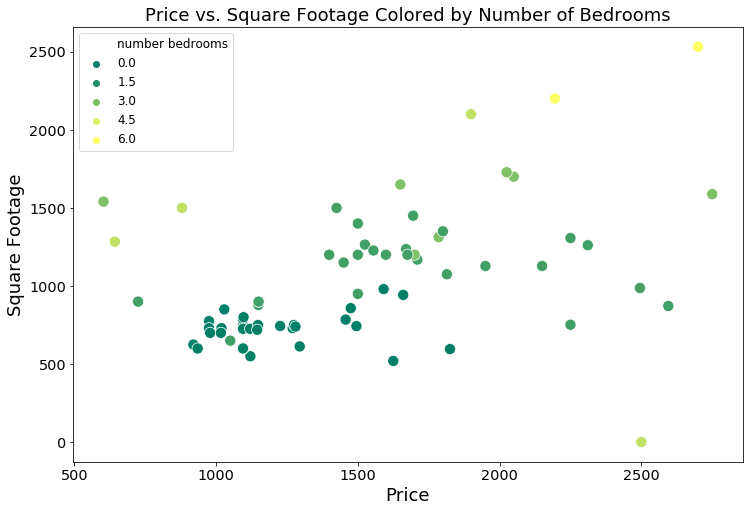

In [638]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


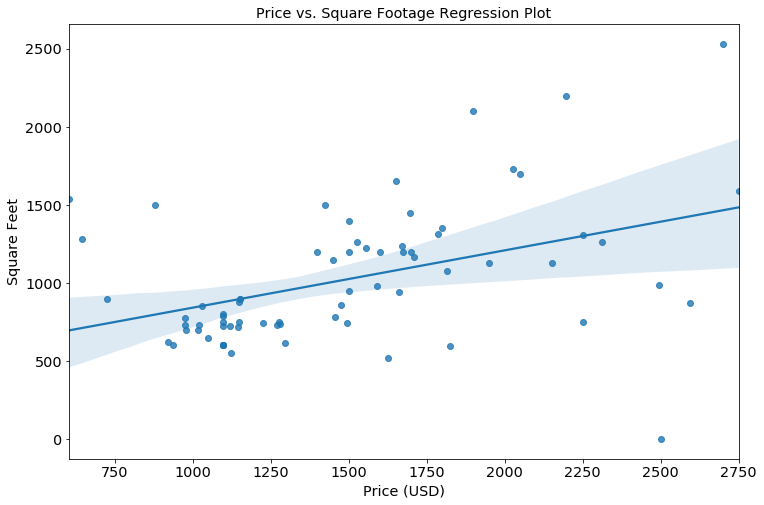

In [639]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [640]:
apts.corr()

,number bedrooms,sqft,price
number bedrooms,1.000000,0.749553,0.524733
sqft,0.749553,1.000000,0.401551
price,0.524733,0.401551,1.000000


In [641]:
apts.groupby('neighborhoods').mean()

,number bedrooms,sqft,price
neighborhoods,,,
,2.000000,1650.000000,1222.500000
Blaine,2.000000,1475.000000,1560.000000
Bloomington,1.000000,720.000000,1145.000000
Bredesen Park,2.000000,1261.000000,2311.000000
Brooklyn Park,2.000000,1157.500000,789.000000
Burnsville,2.166667,1292.333333,1549.500000
CARAG,1.333333,1350.000000,1241.666667
Central,2.000000,950.000000,1500.000000
Champlin,1.000000,550.000000,1121.000000


In [642]:
#correct oddly named locations
apts['neighborhoods'].replace('Uptown Minneapolis', 'Uptown', inplace=True)

apts.groupby('neighborhoods').mean()['price'].sort_values()

neighborhoods
Minnetonka                          400.000000
Riverview                           643.000000
Le Sueur                            725.000000
Columbia Heights                    725.000000
Brooklyn Park                       789.000000
Prospect Park - East River Road     880.000000
Stevens Square - Loring Heights     915.000000
Richfield                           935.000000
Diamond Lake                        979.000000
West St. Paul                      1025.666667
West Calhoun                       1095.000000
Howe                               1095.000000
Holland                            1100.000000
Roseville                          1107.500000
Champlin                           1121.000000
Bloomington                        1145.000000
Powderhorn Park                    1150.000000
                                   1222.500000
East Isles                         1237.500000
CARAG                              1241.666667
St. Paul                           1242.700000

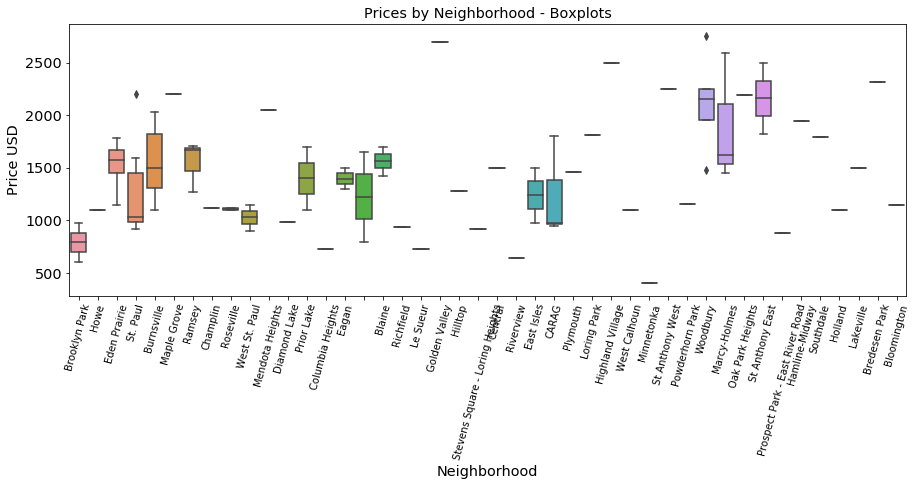

In [647]:
sns.boxplot(x='neighborhoods', y='price', data=apts) #[apts['number bedrooms']==1])
plt.xlabel("Neighborhood");
plt.xticks(rotation=75,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

In [648]:
apts[apts['neighborhoods']=='CARAG']

,posted,neighborhood,post title,number bedrooms,sqft,URL,price,cities,towns,neighborhoods,zips,types,parking,laundry
48,2020-06-02 08:53:00,(3332 Hennepin Avenue),Uptown--3 blocks to Calhoun $100 LEASE SIGNING...,1.0,NaN,https://minneapolis.craigslist.org/hnp/apa/d/m...,950,Minneapolis,,CARAG,55408,1,4,
51,2020-06-02 08:52:00,(3332 Hennepin Avenue),Uptown--3 blocks to Calhoun--$100 LEASE SIGNIN...,1.0,NaN,https://minneapolis.craigslist.org/hnp/apa/d/m...,975,Minneapolis,,CARAG,55408,1,4,
55,2020-06-02 08:42:00,(3837 Aldrich Ave South),Pet Friendly Lake Harriet 2nd Fl Duplex Avail ...,2.0,1350.0,https://minneapolis.craigslist.org/hnp/apa/d/m...,1800,Minneapolis,,CARAG,55409,4,3,4
